In [61]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
from kerastuner import HyperModel

NUMERIC_FEATURES = [
    'p1_height',
    'p2_height',
    'p1_age',
    'p2_age',
    'p1_rating',
    'p2_rating',
    'p1_dev',
    'p2_dev',
    'p1_surface_rating',
    'p2_surface_rating',
    'p1_surface_dev',
    'p2_surface_dev',
    'p1_w',
    'p2_w',
    'p1_l',
    'p2_l',
    'p1_surface_w',
    'p2_surface_w',
    'p1_surface_l',
    'p2_surface_l',
    'p1_inactive_days',
    'p2_inactive_days',
    'p1_recent_rating',
    'p2_recent_rating'
]
CATEGORICAL_FEATURES = [
    'is_hard',
    'is_clay',
    'is_grass',
    'is_bo5',
    'p1_lefty',
    'p2_lefty',
    'p1_home',
    'p2_home'
    
]

dataframe = pd.read_csv('../data/matches.csv')[7389:76425]
validation = pd.read_csv('../data/matches.csv')[76425:]


def build_model(preprocessing_head, inputs, hidden_layer, learning_rate, dropout):
  body = tf.keras.Sequential([
    keras.layers.InputLayer(input_shape=(32,)),
    keras.layers.Dense(hidden_layer, activation='relu'),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(1, activation='sigmoid')
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(learning_rate),
                metrics='acc')
  return model


In [62]:
class MyHyperModel(HyperModel):
    def __init__(self, preprocessing_head, inputs):
        self.preprocessing_head = preprocessing_head
        self.inputs = inputs
    def build(self, hp):
        body = tf.keras.Sequential([
            keras.layers.InputLayer(input_shape=(32,)),
            keras.layers.Dense(hp.Int('hidden_size', 200, 600), activation='relu'),
            keras.layers.Dropout(hp.Float('dropout', 0.05, 0.5)),
            keras.layers.Dense(1, activation='sigmoid')
        ])

        preprocessed_inputs = self.preprocessing_head(self.inputs)
        result = body(preprocessed_inputs)
        model = tf.keras.Model(self.inputs, result)

        model.compile(
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 0.003, 0.03)),
                      metrics=['acc']
                      )
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Int("batch_size", 2000, 6000),
            **kwargs,
        )

In [63]:
def get_model(dataframe, hidden_layer, learning_rate, dropout):
    labels = dataframe.pop('p1_win')
    dataframe.pop('match_hash')
    dataframe.pop('tourney_name')
    dataframe.pop('tourney_date')
    dataframe.pop('p1_name')
    dataframe.pop('p2_name')

    dataframe_features = dataframe.copy()

    inputs = {}

    # match column names with input objects
    for name, column in dataframe_features.items():
        dtype = tf.float32
        inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

    numeric_inputs = {name:input for name,input in inputs.items()
                    if name in NUMERIC_FEATURES}

    # normalize the numeric inputs and gather them in an array
    x = keras.layers.Concatenate()(list(numeric_inputs.values()))
    norm = keras.layers.Normalization()
    norm.adapt(np.array(dataframe[numeric_inputs.keys()]))
    all_numeric_inputs = norm(x)

    preprocessed_inputs = [all_numeric_inputs]

    for name, input in inputs.items():
        if name in NUMERIC_FEATURES:
            continue
        preprocessed_inputs.append(input)

    preprocessed_inputs_cat = keras.layers.Concatenate()(preprocessed_inputs)
    preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

    features_dict = {name: np.array(value) for name, value in dataframe_features.items()}
    f_dict = {name:values for name, values in features_dict.items()}
    preprocessing(f_dict)

    # data_model = MyHyperModel(preprocessing, inputs)
    data_model = build_model(preprocessing, inputs, hidden_layer, learning_rate, dropout)

    return data_model, features_dict, labels

In [64]:
for hidden_layer in range(1300, 1301):
    for learning_rate in range(5, 6):
        learning_rate = learning_rate / 10000
        for int_dropout in range(15, 86, 5):
            dropout = int_dropout / 100
            # dataframe = pd.read_csv('../data/matches.csv')[7389:76425]
            # validation = pd.read_csv('../data/matches.csv')[76425:]
            dataframe = pd.read_csv('../data/matches.csv')[7389:51327]
            validation = pd.read_csv('../data/matches.csv')[51327:68157]
            # validation = pd.read_csv('../data/matches.csv')[51327:]
            data_model, features_dict, labels = get_model(dataframe, hidden_layer, learning_rate, dropout)
            _, val_features_dict, val_labels = get_model(validation, hidden_layer, learning_rate, dropout)

            for trial in range(5):
                data_model.fit(x=features_dict, y=labels, epochs=20000, batch_size=5696, 
                            callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=10)],
                            validation_data=(val_features_dict, val_labels),
                    )
                data_model.save(f'hidden{hidden_layer}lr{learning_rate}dropout{dropout}trial{trial}')

                # data_model.save(f'test{trial}')



# data_model, features_dict, labels = get_model(dataframe, 0,0,0)
# _, val_features_dict, val_labels = get_model(validation, 0,0,0)
# tuner = kt.BayesianOptimization(data_model, objective='loss', directory='training_weights', max_trials=80)
# tuner.search(x=features_dict, y=labels, epochs=20000, 
#              validation_data=(val_features_dict, val_labels),
#              callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=15)]
#             )

Epoch 1/20000
8/8 [==============================] - 4s 271ms/step - loss: 0.6754 - acc: 0.5712 - val_loss: 0.6627 - val_acc: 0.5986
Epoch 2/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.6403 - acc: 0.6320 - val_loss: 0.6517 - val_acc: 0.6201
Epoch 3/20000
8/8 [==============================] - 1s 189ms/step - loss: 0.6251 - acc: 0.6511 - val_loss: 0.6418 - val_acc: 0.6315
Epoch 4/20000
8/8 [==============================] - 1s 150ms/step - loss: 0.6179 - acc: 0.6589 - val_loss: 0.6355 - val_acc: 0.6384
Epoch 5/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.6142 - acc: 0.6604 - val_loss: 0.6341 - val_acc: 0.6393
Epoch 6/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.6122 - acc: 0.6638 - val_loss: 0.6346 - val_acc: 0.6395
Epoch 7/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.6119 - acc: 0.6621 - val_loss: 0.6350 - val_acc: 0.6394
Epoch 8/20000
8/8 [==============================] - 1s 161ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0003dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0003dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 225ms/step - loss: 0.5912 - acc: 0.6807 - val_loss: 0.6281 - val_acc: 0.6466
Epoch 2/20000
8/8 [==============================] - 2s 191ms/step - loss: 0.5915 - acc: 0.6820 - val_loss: 0.6285 - val_acc: 0.6450
Epoch 3/20000
8/8 [==============================] - 1s 189ms/step - loss: 0.5920 - acc: 0.6814 - val_loss: 0.6283 - val_acc: 0.6468
Epoch 4/20000
8/8 [==============================] - 1s 186ms/step - loss: 0.5923 - acc: 0.6787 - val_loss: 0.6283 - val_acc: 0.6458
Epoch 5/20000
8/8 [==============================] - 2s 193ms/step - loss: 0.5929 - acc: 0.6796 - val_loss: 0.6283 - val_acc: 0.6463
Epoch 6/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.5921 - acc: 0.6800 - val_loss: 0.6285 - val_acc: 0.6458
Epoch 7/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5917 - acc: 0.6830 - val_loss: 0.6280 - val_acc: 0.6464
Epoch 8/20000
8/8 [==============================] - 1s 138ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0003dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0003dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 1s 183ms/step - loss: 0.5911 - acc: 0.6823 - val_loss: 0.6282 - val_acc: 0.6456
Epoch 2/20000
8/8 [==============================] - 1s 147ms/step - loss: 0.5912 - acc: 0.6800 - val_loss: 0.6288 - val_acc: 0.6457
Epoch 3/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.5911 - acc: 0.6816 - val_loss: 0.6283 - val_acc: 0.6469
Epoch 4/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5913 - acc: 0.6817 - val_loss: 0.6281 - val_acc: 0.6465
Epoch 5/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.5909 - acc: 0.6821 - val_loss: 0.6285 - val_acc: 0.6460
Epoch 6/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.5912 - acc: 0.6818 - val_loss: 0.6285 - val_acc: 0.6463
Epoch 7/20000
8/8 [==============================] - 1s 144ms/step - loss: 0.5911 - acc: 0.6826 - val_loss: 0.6288 - val_acc: 0.6451
Epoch 8/20000
8/8 [==============================] - 1s 145ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0003dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0003dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.5881 - acc: 0.6856 - val_loss: 0.6298 - val_acc: 0.6448
Epoch 2/20000
8/8 [==============================] - 1s 142ms/step - loss: 0.5883 - acc: 0.6854 - val_loss: 0.6287 - val_acc: 0.6465
Epoch 3/20000
8/8 [==============================] - 1s 125ms/step - loss: 0.5878 - acc: 0.6852 - val_loss: 0.6289 - val_acc: 0.6463
Epoch 4/20000
8/8 [==============================] - 1s 124ms/step - loss: 0.5878 - acc: 0.6850 - val_loss: 0.6294 - val_acc: 0.6449
Epoch 5/20000
8/8 [==============================] - 1s 123ms/step - loss: 0.5885 - acc: 0.6836 - val_loss: 0.6291 - val_acc: 0.6455
Epoch 6/20000
8/8 [==============================] - 1s 146ms/step - loss: 0.5876 - acc: 0.6839 - val_loss: 0.6294 - val_acc: 0.6455
Epoch 7/20000
8/8 [==============================] - 1s 128ms/step - loss: 0.5877 - acc: 0.6840 - val_loss: 0.6291 - val_acc: 0.6446
Epoch 8/20000
8/8 [==============================] - 1s 132ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0003dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0003dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 1s 150ms/step - loss: 0.5861 - acc: 0.6865 - val_loss: 0.6296 - val_acc: 0.6449
Epoch 2/20000
8/8 [==============================] - 1s 125ms/step - loss: 0.5859 - acc: 0.6861 - val_loss: 0.6301 - val_acc: 0.6439
Epoch 3/20000
8/8 [==============================] - 1s 145ms/step - loss: 0.5862 - acc: 0.6859 - val_loss: 0.6298 - val_acc: 0.6452
Epoch 4/20000
8/8 [==============================] - 1s 135ms/step - loss: 0.5857 - acc: 0.6870 - val_loss: 0.6300 - val_acc: 0.6440
Epoch 5/20000
8/8 [==============================] - 1s 131ms/step - loss: 0.5858 - acc: 0.6858 - val_loss: 0.6298 - val_acc: 0.6437
Epoch 6/20000
8/8 [==============================] - 1s 152ms/step - loss: 0.5853 - acc: 0.6860 - val_loss: 0.6296 - val_acc: 0.6444
Epoch 7/20000
8/8 [==============================] - 1s 134ms/step - loss: 0.5853 - acc: 0.6863 - val_loss: 0.6295 - val_acc: 0.6450
Epoch 8/20000
8/8 [==============================] - 1s 148ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0003dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0003dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 5s 370ms/step - loss: 0.6744 - acc: 0.5713 - val_loss: 0.6566 - val_acc: 0.6070
Epoch 2/20000
8/8 [==============================] - 2s 209ms/step - loss: 0.6325 - acc: 0.6449 - val_loss: 0.6508 - val_acc: 0.6209
Epoch 3/20000
8/8 [==============================] - 1s 186ms/step - loss: 0.6195 - acc: 0.6558 - val_loss: 0.6408 - val_acc: 0.6336
Epoch 4/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.6132 - acc: 0.6640 - val_loss: 0.6351 - val_acc: 0.6371
Epoch 5/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.6119 - acc: 0.6644 - val_loss: 0.6350 - val_acc: 0.6400
Epoch 6/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.6114 - acc: 0.6634 - val_loss: 0.6361 - val_acc: 0.6378
Epoch 7/20000
8/8 [==============================] - 2s 232ms/step - loss: 0.6098 - acc: 0.6637 - val_loss: 0.6359 - val_acc: 0.6381
Epoch 8/20000
8/8 [==============================] - 2s 196ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0004dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0004dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 208ms/step - loss: 0.5867 - acc: 0.6855 - val_loss: 0.6301 - val_acc: 0.6456
Epoch 2/20000
8/8 [==============================] - 1s 148ms/step - loss: 0.5874 - acc: 0.6864 - val_loss: 0.6293 - val_acc: 0.6453
Epoch 3/20000
8/8 [==============================] - 1s 143ms/step - loss: 0.5866 - acc: 0.6845 - val_loss: 0.6296 - val_acc: 0.6456
Epoch 4/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.5864 - acc: 0.6841 - val_loss: 0.6302 - val_acc: 0.6461
Epoch 5/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.5863 - acc: 0.6874 - val_loss: 0.6296 - val_acc: 0.6458
Epoch 6/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.5867 - acc: 0.6861 - val_loss: 0.6301 - val_acc: 0.6454
Epoch 7/20000
8/8 [==============================] - 1s 152ms/step - loss: 0.5878 - acc: 0.6868 - val_loss: 0.6297 - val_acc: 0.6458
Epoch 8/20000
8/8 [==============================] - 1s 150ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0004dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0004dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 296ms/step - loss: 0.5831 - acc: 0.6878 - val_loss: 0.6304 - val_acc: 0.6441
Epoch 2/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.5833 - acc: 0.6893 - val_loss: 0.6305 - val_acc: 0.6440
Epoch 3/20000
8/8 [==============================] - 2s 217ms/step - loss: 0.5829 - acc: 0.6893 - val_loss: 0.6309 - val_acc: 0.6450
Epoch 4/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.5831 - acc: 0.6896 - val_loss: 0.6302 - val_acc: 0.6441
Epoch 5/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5829 - acc: 0.6887 - val_loss: 0.6312 - val_acc: 0.6457
Epoch 6/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.5839 - acc: 0.6874 - val_loss: 0.6301 - val_acc: 0.6443
Epoch 7/20000
8/8 [==============================] - 1s 184ms/step - loss: 0.5829 - acc: 0.6888 - val_loss: 0.6303 - val_acc: 0.6442
Epoch 8/20000
8/8 [==============================] - 2s 195ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0004dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0004dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 198ms/step - loss: 0.5806 - acc: 0.6911 - val_loss: 0.6316 - val_acc: 0.6446
Epoch 2/20000
8/8 [==============================] - 1s 140ms/step - loss: 0.5813 - acc: 0.6889 - val_loss: 0.6317 - val_acc: 0.6455
Epoch 3/20000
8/8 [==============================] - 1s 153ms/step - loss: 0.5800 - acc: 0.6887 - val_loss: 0.6310 - val_acc: 0.6451
Epoch 4/20000
8/8 [==============================] - 1s 148ms/step - loss: 0.5807 - acc: 0.6916 - val_loss: 0.6321 - val_acc: 0.6453
Epoch 5/20000
8/8 [==============================] - 1s 132ms/step - loss: 0.5817 - acc: 0.6911 - val_loss: 0.6318 - val_acc: 0.6449
Epoch 6/20000
8/8 [==============================] - 1s 150ms/step - loss: 0.5813 - acc: 0.6910 - val_loss: 0.6316 - val_acc: 0.6449
Epoch 7/20000
8/8 [==============================] - 1s 145ms/step - loss: 0.5804 - acc: 0.6911 - val_loss: 0.6319 - val_acc: 0.6448
Epoch 8/20000
8/8 [==============================] - 1s 133ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0004dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0004dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.5780 - acc: 0.6942 - val_loss: 0.6318 - val_acc: 0.6450
Epoch 2/20000
8/8 [==============================] - 1s 147ms/step - loss: 0.5797 - acc: 0.6910 - val_loss: 0.6325 - val_acc: 0.6450
Epoch 3/20000
8/8 [==============================] - 1s 145ms/step - loss: 0.5786 - acc: 0.6902 - val_loss: 0.6319 - val_acc: 0.6446
Epoch 4/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.5790 - acc: 0.6919 - val_loss: 0.6325 - val_acc: 0.6447
Epoch 5/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5788 - acc: 0.6927 - val_loss: 0.6319 - val_acc: 0.6455
Epoch 6/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.5779 - acc: 0.6923 - val_loss: 0.6324 - val_acc: 0.6444
Epoch 7/20000
8/8 [==============================] - 2s 195ms/step - loss: 0.5788 - acc: 0.6920 - val_loss: 0.6323 - val_acc: 0.6452
Epoch 8/20000
8/8 [==============================] - 2s 210ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0004dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0004dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 3s 248ms/step - loss: 0.6624 - acc: 0.5962 - val_loss: 0.6485 - val_acc: 0.6216
Epoch 2/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.6267 - acc: 0.6495 - val_loss: 0.6451 - val_acc: 0.6298
Epoch 3/20000
8/8 [==============================] - 1s 169ms/step - loss: 0.6169 - acc: 0.6592 - val_loss: 0.6374 - val_acc: 0.6373
Epoch 4/20000
8/8 [==============================] - 2s 214ms/step - loss: 0.6130 - acc: 0.6625 - val_loss: 0.6364 - val_acc: 0.6408
Epoch 5/20000
8/8 [==============================] - 2s 212ms/step - loss: 0.6124 - acc: 0.6640 - val_loss: 0.6370 - val_acc: 0.6408
Epoch 6/20000
8/8 [==============================] - 1s 142ms/step - loss: 0.6096 - acc: 0.6646 - val_loss: 0.6373 - val_acc: 0.6400
Epoch 7/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.6094 - acc: 0.6653 - val_loss: 0.6351 - val_acc: 0.6401
Epoch 8/20000
8/8 [==============================] - 1s 136ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0005dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0005dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5826 - acc: 0.6901 - val_loss: 0.6319 - val_acc: 0.6437
Epoch 2/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.5819 - acc: 0.6899 - val_loss: 0.6316 - val_acc: 0.6437
Epoch 3/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5821 - acc: 0.6908 - val_loss: 0.6317 - val_acc: 0.6442
Epoch 4/20000
8/8 [==============================] - 1s 141ms/step - loss: 0.5812 - acc: 0.6938 - val_loss: 0.6315 - val_acc: 0.6437
Epoch 5/20000
8/8 [==============================] - 1s 140ms/step - loss: 0.5822 - acc: 0.6895 - val_loss: 0.6319 - val_acc: 0.6444
Epoch 6/20000
8/8 [==============================] - 1s 183ms/step - loss: 0.5811 - acc: 0.6913 - val_loss: 0.6323 - val_acc: 0.6441
Epoch 7/20000
8/8 [==============================] - 1s 148ms/step - loss: 0.5815 - acc: 0.6892 - val_loss: 0.6310 - val_acc: 0.6439
Epoch 8/20000
8/8 [==============================] - 1s 177ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0005dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0005dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 1s 156ms/step - loss: 0.5804 - acc: 0.6918 - val_loss: 0.6324 - val_acc: 0.6433
Epoch 2/20000
8/8 [==============================] - 1s 131ms/step - loss: 0.5807 - acc: 0.6920 - val_loss: 0.6318 - val_acc: 0.6436
Epoch 3/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5806 - acc: 0.6914 - val_loss: 0.6321 - val_acc: 0.6434
Epoch 4/20000
8/8 [==============================] - 1s 160ms/step - loss: 0.5812 - acc: 0.6888 - val_loss: 0.6321 - val_acc: 0.6422
Epoch 5/20000
8/8 [==============================] - 1s 142ms/step - loss: 0.5797 - acc: 0.6915 - val_loss: 0.6327 - val_acc: 0.6437
Epoch 6/20000
8/8 [==============================] - 1s 142ms/step - loss: 0.5794 - acc: 0.6918 - val_loss: 0.6320 - val_acc: 0.6429
Epoch 7/20000
8/8 [==============================] - 1s 142ms/step - loss: 0.5807 - acc: 0.6888 - val_loss: 0.6324 - val_acc: 0.6428
Epoch 8/20000
8/8 [==============================] - 1s 161ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0005dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0005dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.5794 - acc: 0.6923 - val_loss: 0.6329 - val_acc: 0.6437
Epoch 2/20000
8/8 [==============================] - 1s 124ms/step - loss: 0.5794 - acc: 0.6901 - val_loss: 0.6326 - val_acc: 0.6434
Epoch 3/20000
8/8 [==============================] - 1s 127ms/step - loss: 0.5800 - acc: 0.6903 - val_loss: 0.6334 - val_acc: 0.6427
Epoch 4/20000
8/8 [==============================] - 1s 151ms/step - loss: 0.5798 - acc: 0.6909 - val_loss: 0.6328 - val_acc: 0.6430
Epoch 5/20000
8/8 [==============================] - 1s 129ms/step - loss: 0.5793 - acc: 0.6929 - val_loss: 0.6331 - val_acc: 0.6450
Epoch 6/20000
8/8 [==============================] - 1s 129ms/step - loss: 0.5782 - acc: 0.6936 - val_loss: 0.6322 - val_acc: 0.6439
Epoch 7/20000
8/8 [==============================] - 1s 132ms/step - loss: 0.5793 - acc: 0.6925 - val_loss: 0.6324 - val_acc: 0.6437
Epoch 8/20000
8/8 [==============================] - 1s 127ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0005dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0005dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.5768 - acc: 0.6947 - val_loss: 0.6337 - val_acc: 0.6424
Epoch 2/20000
8/8 [==============================] - 1s 138ms/step - loss: 0.5761 - acc: 0.6948 - val_loss: 0.6338 - val_acc: 0.6441
Epoch 3/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.5767 - acc: 0.6948 - val_loss: 0.6341 - val_acc: 0.6424
Epoch 4/20000
8/8 [==============================] - 1s 142ms/step - loss: 0.5776 - acc: 0.6921 - val_loss: 0.6337 - val_acc: 0.6440
Epoch 5/20000
8/8 [==============================] - 1s 146ms/step - loss: 0.5752 - acc: 0.6945 - val_loss: 0.6340 - val_acc: 0.6432
Epoch 6/20000
8/8 [==============================] - 1s 149ms/step - loss: 0.5774 - acc: 0.6935 - val_loss: 0.6343 - val_acc: 0.6442
Epoch 7/20000
8/8 [==============================] - 1s 146ms/step - loss: 0.5768 - acc: 0.6955 - val_loss: 0.6345 - val_acc: 0.6419
Epoch 8/20000
8/8 [==============================] - 1s 156ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0005dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0005dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 168ms/step - loss: 0.6641 - acc: 0.5916 - val_loss: 0.6506 - val_acc: 0.6187
Epoch 2/20000
8/8 [==============================] - 1s 128ms/step - loss: 0.6232 - acc: 0.6538 - val_loss: 0.6451 - val_acc: 0.6331
Epoch 3/20000
8/8 [==============================] - 1s 146ms/step - loss: 0.6155 - acc: 0.6597 - val_loss: 0.6372 - val_acc: 0.6402
Epoch 4/20000
8/8 [==============================] - 1s 131ms/step - loss: 0.6113 - acc: 0.6637 - val_loss: 0.6366 - val_acc: 0.6415
Epoch 5/20000
8/8 [==============================] - 1s 129ms/step - loss: 0.6106 - acc: 0.6651 - val_loss: 0.6357 - val_acc: 0.6406
Epoch 6/20000
8/8 [==============================] - 1s 131ms/step - loss: 0.6092 - acc: 0.6641 - val_loss: 0.6345 - val_acc: 0.6408
Epoch 7/20000
8/8 [==============================] - 1s 134ms/step - loss: 0.6075 - acc: 0.6653 - val_loss: 0.6332 - val_acc: 0.6422
Epoch 8/20000
8/8 [==============================] - 1s 145ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0006dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0006dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.5854 - acc: 0.6873 - val_loss: 0.6304 - val_acc: 0.6455
Epoch 2/20000
8/8 [==============================] - 1s 136ms/step - loss: 0.5852 - acc: 0.6876 - val_loss: 0.6316 - val_acc: 0.6440
Epoch 3/20000
8/8 [==============================] - 1s 145ms/step - loss: 0.5861 - acc: 0.6870 - val_loss: 0.6310 - val_acc: 0.6454
Epoch 4/20000
8/8 [==============================] - 1s 140ms/step - loss: 0.5851 - acc: 0.6858 - val_loss: 0.6313 - val_acc: 0.6433
Epoch 5/20000
8/8 [==============================] - 1s 141ms/step - loss: 0.5858 - acc: 0.6841 - val_loss: 0.6342 - val_acc: 0.6408
Epoch 6/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.5858 - acc: 0.6871 - val_loss: 0.6303 - val_acc: 0.6446
Epoch 7/20000
8/8 [==============================] - 1s 150ms/step - loss: 0.5848 - acc: 0.6871 - val_loss: 0.6305 - val_acc: 0.6441
Epoch 8/20000
8/8 [==============================] - 1s 161ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0006dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0006dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5820 - acc: 0.6883 - val_loss: 0.6337 - val_acc: 0.6426
Epoch 2/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5818 - acc: 0.6898 - val_loss: 0.6321 - val_acc: 0.6440
Epoch 3/20000
8/8 [==============================] - 2s 212ms/step - loss: 0.5808 - acc: 0.6909 - val_loss: 0.6343 - val_acc: 0.6416
Epoch 4/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5823 - acc: 0.6883 - val_loss: 0.6314 - val_acc: 0.6447
Epoch 5/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5813 - acc: 0.6909 - val_loss: 0.6317 - val_acc: 0.6444
Epoch 6/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.5807 - acc: 0.6904 - val_loss: 0.6334 - val_acc: 0.6442
Epoch 7/20000
8/8 [==============================] - 1s 153ms/step - loss: 0.5814 - acc: 0.6905 - val_loss: 0.6351 - val_acc: 0.6404
Epoch 8/20000
8/8 [==============================] - 1s 175ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0006dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0006dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 179ms/step - loss: 0.5780 - acc: 0.6930 - val_loss: 0.6338 - val_acc: 0.6449
Epoch 2/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.5762 - acc: 0.6945 - val_loss: 0.6334 - val_acc: 0.6447
Epoch 3/20000
8/8 [==============================] - 1s 183ms/step - loss: 0.5777 - acc: 0.6907 - val_loss: 0.6342 - val_acc: 0.6444
Epoch 4/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.5768 - acc: 0.6953 - val_loss: 0.6336 - val_acc: 0.6453
Epoch 5/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5765 - acc: 0.6941 - val_loss: 0.6332 - val_acc: 0.6443
Epoch 6/20000
8/8 [==============================] - 1s 149ms/step - loss: 0.5763 - acc: 0.6946 - val_loss: 0.6336 - val_acc: 0.6443
Epoch 7/20000
8/8 [==============================] - 1s 151ms/step - loss: 0.5779 - acc: 0.6944 - val_loss: 0.6341 - val_acc: 0.6443
Epoch 8/20000
8/8 [==============================] - 1s 174ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0006dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0006dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.5745 - acc: 0.6969 - val_loss: 0.6345 - val_acc: 0.6422
Epoch 2/20000
8/8 [==============================] - 1s 140ms/step - loss: 0.5755 - acc: 0.6927 - val_loss: 0.6344 - val_acc: 0.6432
Epoch 3/20000
8/8 [==============================] - 1s 148ms/step - loss: 0.5741 - acc: 0.6969 - val_loss: 0.6348 - val_acc: 0.6423
Epoch 4/20000
8/8 [==============================] - 1s 140ms/step - loss: 0.5747 - acc: 0.6981 - val_loss: 0.6359 - val_acc: 0.6428
Epoch 5/20000
8/8 [==============================] - 1s 124ms/step - loss: 0.5745 - acc: 0.6957 - val_loss: 0.6342 - val_acc: 0.6433
Epoch 6/20000
8/8 [==============================] - 1s 142ms/step - loss: 0.5752 - acc: 0.6949 - val_loss: 0.6340 - val_acc: 0.6419
Epoch 7/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.5748 - acc: 0.6961 - val_loss: 0.6354 - val_acc: 0.6434
Epoch 8/20000
8/8 [==============================] - 1s 135ms/step - 

INFO:tensorflow:Assets written to: hidden1000lr0.0006dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1000lr0.0006dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 3s 243ms/step - loss: 0.6726 - acc: 0.5753 - val_loss: 0.6610 - val_acc: 0.5999
Epoch 2/20000
8/8 [==============================] - 1s 146ms/step - loss: 0.6375 - acc: 0.6393 - val_loss: 0.6509 - val_acc: 0.6196
Epoch 3/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.6243 - acc: 0.6534 - val_loss: 0.6407 - val_acc: 0.6304
Epoch 4/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.6167 - acc: 0.6599 - val_loss: 0.6345 - val_acc: 0.6370
Epoch 5/20000
8/8 [==============================] - 2s 202ms/step - loss: 0.6129 - acc: 0.6621 - val_loss: 0.6332 - val_acc: 0.6395
Epoch 6/20000
8/8 [==============================] - 1s 189ms/step - loss: 0.6109 - acc: 0.6647 - val_loss: 0.6340 - val_acc: 0.6399
Epoch 7/20000
8/8 [==============================] - 1s 153ms/step - loss: 0.6104 - acc: 0.6645 - val_loss: 0.6347 - val_acc: 0.6395
Epoch 8/20000
8/8 [==============================] - 1s 185ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0003dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0003dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.5905 - acc: 0.6834 - val_loss: 0.6287 - val_acc: 0.6455
Epoch 2/20000
8/8 [==============================] - 1s 147ms/step - loss: 0.5901 - acc: 0.6842 - val_loss: 0.6288 - val_acc: 0.6463
Epoch 3/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.5900 - acc: 0.6823 - val_loss: 0.6290 - val_acc: 0.6450
Epoch 4/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5897 - acc: 0.6833 - val_loss: 0.6291 - val_acc: 0.6456
Epoch 5/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.5899 - acc: 0.6819 - val_loss: 0.6289 - val_acc: 0.6465
Epoch 6/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5899 - acc: 0.6827 - val_loss: 0.6288 - val_acc: 0.6448
Epoch 7/20000
8/8 [==============================] - 2s 211ms/step - loss: 0.5894 - acc: 0.6837 - val_loss: 0.6287 - val_acc: 0.6448
Epoch 8/20000
8/8 [==============================] - 2s 209ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0003dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0003dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 211ms/step - loss: 0.5862 - acc: 0.6859 - val_loss: 0.6294 - val_acc: 0.6447
Epoch 2/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5869 - acc: 0.6856 - val_loss: 0.6294 - val_acc: 0.6448
Epoch 3/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.5867 - acc: 0.6865 - val_loss: 0.6297 - val_acc: 0.6448
Epoch 4/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5863 - acc: 0.6872 - val_loss: 0.6297 - val_acc: 0.6461
Epoch 5/20000
8/8 [==============================] - 2s 193ms/step - loss: 0.5864 - acc: 0.6864 - val_loss: 0.6292 - val_acc: 0.6447
Epoch 6/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.5862 - acc: 0.6868 - val_loss: 0.6298 - val_acc: 0.6445
Epoch 7/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5866 - acc: 0.6855 - val_loss: 0.6301 - val_acc: 0.6445
Epoch 8/20000
8/8 [==============================] - 1s 175ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0003dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0003dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 303ms/step - loss: 0.5851 - acc: 0.6861 - val_loss: 0.6301 - val_acc: 0.6439
Epoch 2/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5854 - acc: 0.6868 - val_loss: 0.6298 - val_acc: 0.6450
Epoch 3/20000
8/8 [==============================] - 2s 193ms/step - loss: 0.5856 - acc: 0.6861 - val_loss: 0.6298 - val_acc: 0.6440
Epoch 4/20000
8/8 [==============================] - 1s 168ms/step - loss: 0.5857 - acc: 0.6859 - val_loss: 0.6301 - val_acc: 0.6448
Epoch 5/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.5852 - acc: 0.6877 - val_loss: 0.6294 - val_acc: 0.6447
Epoch 6/20000
8/8 [==============================] - 2s 237ms/step - loss: 0.5853 - acc: 0.6876 - val_loss: 0.6299 - val_acc: 0.6442
Epoch 7/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5853 - acc: 0.6878 - val_loss: 0.6297 - val_acc: 0.6439
Epoch 8/20000
8/8 [==============================] - 1s 186ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0003dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0003dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 212ms/step - loss: 0.5835 - acc: 0.6875 - val_loss: 0.6306 - val_acc: 0.6443
Epoch 2/20000
8/8 [==============================] - 1s 151ms/step - loss: 0.5840 - acc: 0.6896 - val_loss: 0.6304 - val_acc: 0.6450
Epoch 3/20000
8/8 [==============================] - 1s 189ms/step - loss: 0.5839 - acc: 0.6884 - val_loss: 0.6305 - val_acc: 0.6447
Epoch 4/20000
8/8 [==============================] - 1s 180ms/step - loss: 0.5837 - acc: 0.6879 - val_loss: 0.6304 - val_acc: 0.6458
Epoch 5/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5844 - acc: 0.6882 - val_loss: 0.6308 - val_acc: 0.6446
Epoch 6/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.5841 - acc: 0.6886 - val_loss: 0.6303 - val_acc: 0.6451
Epoch 7/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5842 - acc: 0.6890 - val_loss: 0.6302 - val_acc: 0.6443
Epoch 8/20000
8/8 [==============================] - 1s 157ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0003dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0003dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 198ms/step - loss: 0.6670 - acc: 0.5900 - val_loss: 0.6505 - val_acc: 0.6163
Epoch 2/20000
8/8 [==============================] - 1s 143ms/step - loss: 0.6286 - acc: 0.6482 - val_loss: 0.6475 - val_acc: 0.6277
Epoch 3/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.6192 - acc: 0.6568 - val_loss: 0.6385 - val_acc: 0.6341
Epoch 4/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.6133 - acc: 0.6623 - val_loss: 0.6346 - val_acc: 0.6395
Epoch 5/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.6124 - acc: 0.6627 - val_loss: 0.6356 - val_acc: 0.6395
Epoch 6/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.6104 - acc: 0.6652 - val_loss: 0.6358 - val_acc: 0.6399
Epoch 7/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.6106 - acc: 0.6648 - val_loss: 0.6354 - val_acc: 0.6406
Epoch 8/20000
8/8 [==============================] - 1s 159ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0004dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0004dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 206ms/step - loss: 0.5819 - acc: 0.6922 - val_loss: 0.6324 - val_acc: 0.6449
Epoch 2/20000
8/8 [==============================] - 1s 149ms/step - loss: 0.5798 - acc: 0.6909 - val_loss: 0.6326 - val_acc: 0.6439
Epoch 3/20000
8/8 [==============================] - 1s 144ms/step - loss: 0.5803 - acc: 0.6917 - val_loss: 0.6322 - val_acc: 0.6439
Epoch 4/20000
8/8 [==============================] - 1s 146ms/step - loss: 0.5803 - acc: 0.6912 - val_loss: 0.6314 - val_acc: 0.6431
Epoch 5/20000
8/8 [==============================] - 1s 144ms/step - loss: 0.5804 - acc: 0.6907 - val_loss: 0.6324 - val_acc: 0.6440
Epoch 6/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5809 - acc: 0.6886 - val_loss: 0.6323 - val_acc: 0.6435
Epoch 7/20000
8/8 [==============================] - 1s 153ms/step - loss: 0.5804 - acc: 0.6921 - val_loss: 0.6319 - val_acc: 0.6427
Epoch 8/20000
8/8 [==============================] - 1s 150ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0004dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0004dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 243ms/step - loss: 0.5808 - acc: 0.6916 - val_loss: 0.6325 - val_acc: 0.6439
Epoch 2/20000
8/8 [==============================] - 2s 189ms/step - loss: 0.5803 - acc: 0.6899 - val_loss: 0.6320 - val_acc: 0.6440
Epoch 3/20000
8/8 [==============================] - 1s 168ms/step - loss: 0.5790 - acc: 0.6925 - val_loss: 0.6326 - val_acc: 0.6425
Epoch 4/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.5804 - acc: 0.6908 - val_loss: 0.6325 - val_acc: 0.6431
Epoch 5/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5800 - acc: 0.6915 - val_loss: 0.6324 - val_acc: 0.6441
Epoch 6/20000
8/8 [==============================] - 2s 185ms/step - loss: 0.5809 - acc: 0.6929 - val_loss: 0.6324 - val_acc: 0.6438
Epoch 7/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5796 - acc: 0.6910 - val_loss: 0.6322 - val_acc: 0.6434
Epoch 8/20000
8/8 [==============================] - 1s 172ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0004dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0004dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 191ms/step - loss: 0.5779 - acc: 0.6926 - val_loss: 0.6329 - val_acc: 0.6441
Epoch 2/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5782 - acc: 0.6923 - val_loss: 0.6339 - val_acc: 0.6433
Epoch 3/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5785 - acc: 0.6929 - val_loss: 0.6345 - val_acc: 0.6425
Epoch 4/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.5776 - acc: 0.6901 - val_loss: 0.6334 - val_acc: 0.6437
Epoch 5/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5774 - acc: 0.6933 - val_loss: 0.6333 - val_acc: 0.6436
Epoch 6/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.5773 - acc: 0.6923 - val_loss: 0.6335 - val_acc: 0.6427
Epoch 7/20000
8/8 [==============================] - 1s 154ms/step - loss: 0.5772 - acc: 0.6941 - val_loss: 0.6338 - val_acc: 0.6434
Epoch 8/20000
8/8 [==============================] - 1s 157ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0004dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0004dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 198ms/step - loss: 0.5775 - acc: 0.6929 - val_loss: 0.6349 - val_acc: 0.6435
Epoch 2/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.5768 - acc: 0.6930 - val_loss: 0.6341 - val_acc: 0.6437
Epoch 3/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5773 - acc: 0.6940 - val_loss: 0.6334 - val_acc: 0.6436
Epoch 4/20000
8/8 [==============================] - 2s 196ms/step - loss: 0.5770 - acc: 0.6963 - val_loss: 0.6346 - val_acc: 0.6421
Epoch 5/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5771 - acc: 0.6936 - val_loss: 0.6337 - val_acc: 0.6423
Epoch 6/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5780 - acc: 0.6917 - val_loss: 0.6340 - val_acc: 0.6438
Epoch 7/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.5761 - acc: 0.6944 - val_loss: 0.6337 - val_acc: 0.6421
Epoch 8/20000
8/8 [==============================] - 1s 158ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0004dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0004dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 3s 197ms/step - loss: 0.6588 - acc: 0.6029 - val_loss: 0.6496 - val_acc: 0.6190
Epoch 2/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.6243 - acc: 0.6507 - val_loss: 0.6448 - val_acc: 0.6311
Epoch 3/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.6153 - acc: 0.6615 - val_loss: 0.6357 - val_acc: 0.6389
Epoch 4/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.6110 - acc: 0.6647 - val_loss: 0.6355 - val_acc: 0.6424
Epoch 5/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.6099 - acc: 0.6639 - val_loss: 0.6360 - val_acc: 0.6419
Epoch 6/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.6084 - acc: 0.6649 - val_loss: 0.6354 - val_acc: 0.6393
Epoch 7/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.6084 - acc: 0.6658 - val_loss: 0.6334 - val_acc: 0.6400
Epoch 8/20000
8/8 [==============================] - 1s 176ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0005dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0005dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 222ms/step - loss: 0.5824 - acc: 0.6896 - val_loss: 0.6327 - val_acc: 0.6444
Epoch 2/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5817 - acc: 0.6886 - val_loss: 0.6320 - val_acc: 0.6454
Epoch 3/20000
8/8 [==============================] - 2s 187ms/step - loss: 0.5819 - acc: 0.6899 - val_loss: 0.6316 - val_acc: 0.6455
Epoch 4/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.5816 - acc: 0.6896 - val_loss: 0.6320 - val_acc: 0.6439
Epoch 5/20000
8/8 [==============================] - 2s 219ms/step - loss: 0.5806 - acc: 0.6920 - val_loss: 0.6314 - val_acc: 0.6446
Epoch 6/20000
8/8 [==============================] - 2s 214ms/step - loss: 0.5814 - acc: 0.6893 - val_loss: 0.6319 - val_acc: 0.6456
Epoch 7/20000
8/8 [==============================] - 2s 243ms/step - loss: 0.5818 - acc: 0.6892 - val_loss: 0.6320 - val_acc: 0.6441
Epoch 8/20000
8/8 [==============================] - 2s 226ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0005dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0005dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 220ms/step - loss: 0.5800 - acc: 0.6920 - val_loss: 0.6320 - val_acc: 0.6444
Epoch 2/20000
8/8 [==============================] - 1s 179ms/step - loss: 0.5804 - acc: 0.6909 - val_loss: 0.6334 - val_acc: 0.6434
Epoch 3/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.5804 - acc: 0.6901 - val_loss: 0.6320 - val_acc: 0.6449
Epoch 4/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5796 - acc: 0.6922 - val_loss: 0.6322 - val_acc: 0.6455
Epoch 5/20000
8/8 [==============================] - 2s 221ms/step - loss: 0.5796 - acc: 0.6923 - val_loss: 0.6328 - val_acc: 0.6443
Epoch 6/20000
8/8 [==============================] - 2s 270ms/step - loss: 0.5801 - acc: 0.6920 - val_loss: 0.6324 - val_acc: 0.6452
Epoch 7/20000
8/8 [==============================] - 2s 213ms/step - loss: 0.5798 - acc: 0.6920 - val_loss: 0.6325 - val_acc: 0.6447
Epoch 8/20000
8/8 [==============================] - 2s 202ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0005dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0005dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.5782 - acc: 0.6948 - val_loss: 0.6329 - val_acc: 0.6453
Epoch 2/20000
8/8 [==============================] - 1s 146ms/step - loss: 0.5784 - acc: 0.6935 - val_loss: 0.6348 - val_acc: 0.6424
Epoch 3/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.5765 - acc: 0.6955 - val_loss: 0.6330 - val_acc: 0.6449
Epoch 4/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5766 - acc: 0.6936 - val_loss: 0.6341 - val_acc: 0.6456
Epoch 5/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5785 - acc: 0.6933 - val_loss: 0.6338 - val_acc: 0.6427
Epoch 6/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.5764 - acc: 0.6931 - val_loss: 0.6329 - val_acc: 0.6456
Epoch 7/20000
8/8 [==============================] - 2s 211ms/step - loss: 0.5773 - acc: 0.6928 - val_loss: 0.6331 - val_acc: 0.6443
Epoch 8/20000
8/8 [==============================] - 1s 175ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0005dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0005dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 212ms/step - loss: 0.5770 - acc: 0.6952 - val_loss: 0.6344 - val_acc: 0.6443
Epoch 2/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.5767 - acc: 0.6955 - val_loss: 0.6334 - val_acc: 0.6445
Epoch 3/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.5763 - acc: 0.6962 - val_loss: 0.6337 - val_acc: 0.6456
Epoch 4/20000
8/8 [==============================] - 1s 162ms/step - loss: 0.5763 - acc: 0.6962 - val_loss: 0.6328 - val_acc: 0.6452
Epoch 5/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.5765 - acc: 0.6954 - val_loss: 0.6340 - val_acc: 0.6447
Epoch 6/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5764 - acc: 0.6946 - val_loss: 0.6344 - val_acc: 0.6433
Epoch 7/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.5762 - acc: 0.6951 - val_loss: 0.6334 - val_acc: 0.6442
Epoch 8/20000
8/8 [==============================] - 2s 216ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0005dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0005dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 4s 317ms/step - loss: 0.6630 - acc: 0.5933 - val_loss: 0.6537 - val_acc: 0.6182
Epoch 2/20000
8/8 [==============================] - 2s 196ms/step - loss: 0.6220 - acc: 0.6524 - val_loss: 0.6405 - val_acc: 0.6359
Epoch 3/20000
8/8 [==============================] - 2s 207ms/step - loss: 0.6133 - acc: 0.6621 - val_loss: 0.6360 - val_acc: 0.6419
Epoch 4/20000
8/8 [==============================] - 1s 189ms/step - loss: 0.6118 - acc: 0.6621 - val_loss: 0.6370 - val_acc: 0.6406
Epoch 5/20000
8/8 [==============================] - 1s 189ms/step - loss: 0.6100 - acc: 0.6653 - val_loss: 0.6367 - val_acc: 0.6394
Epoch 6/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.6088 - acc: 0.6653 - val_loss: 0.6349 - val_acc: 0.6383
Epoch 7/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.6076 - acc: 0.6669 - val_loss: 0.6320 - val_acc: 0.6400
Epoch 8/20000
8/8 [==============================] - 1s 183ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0006dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0006dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 229ms/step - loss: 0.5837 - acc: 0.6886 - val_loss: 0.6303 - val_acc: 0.6441
Epoch 2/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5839 - acc: 0.6882 - val_loss: 0.6312 - val_acc: 0.6445
Epoch 3/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.5836 - acc: 0.6899 - val_loss: 0.6308 - val_acc: 0.6447
Epoch 4/20000
8/8 [==============================] - 2s 193ms/step - loss: 0.5842 - acc: 0.6877 - val_loss: 0.6310 - val_acc: 0.6446
Epoch 5/20000
8/8 [==============================] - 1s 186ms/step - loss: 0.5821 - acc: 0.6891 - val_loss: 0.6311 - val_acc: 0.6441
Epoch 6/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.5830 - acc: 0.6881 - val_loss: 0.6315 - val_acc: 0.6447
Epoch 7/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.5826 - acc: 0.6884 - val_loss: 0.6305 - val_acc: 0.6452
Epoch 8/20000
8/8 [==============================] - 2s 192ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0006dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0006dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 3s 363ms/step - loss: 0.5781 - acc: 0.6928 - val_loss: 0.6335 - val_acc: 0.6445
Epoch 2/20000
8/8 [==============================] - 2s 193ms/step - loss: 0.5791 - acc: 0.6926 - val_loss: 0.6318 - val_acc: 0.6456
Epoch 3/20000
8/8 [==============================] - 2s 208ms/step - loss: 0.5791 - acc: 0.6910 - val_loss: 0.6326 - val_acc: 0.6443
Epoch 4/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.5795 - acc: 0.6935 - val_loss: 0.6320 - val_acc: 0.6443
Epoch 5/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.5791 - acc: 0.6922 - val_loss: 0.6335 - val_acc: 0.6428
Epoch 6/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5796 - acc: 0.6938 - val_loss: 0.6324 - val_acc: 0.6440
Epoch 7/20000
8/8 [==============================] - 1s 169ms/step - loss: 0.5791 - acc: 0.6924 - val_loss: 0.6322 - val_acc: 0.6445
Epoch 8/20000
8/8 [==============================] - 1s 159ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0006dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0006dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.5778 - acc: 0.6943 - val_loss: 0.6318 - val_acc: 0.6451
Epoch 2/20000
8/8 [==============================] - 1s 135ms/step - loss: 0.5779 - acc: 0.6920 - val_loss: 0.6336 - val_acc: 0.6443
Epoch 3/20000
8/8 [==============================] - 1s 136ms/step - loss: 0.5777 - acc: 0.6934 - val_loss: 0.6325 - val_acc: 0.6443
Epoch 4/20000
8/8 [==============================] - 1s 153ms/step - loss: 0.5789 - acc: 0.6924 - val_loss: 0.6334 - val_acc: 0.6448
Epoch 5/20000
8/8 [==============================] - 1s 150ms/step - loss: 0.5796 - acc: 0.6903 - val_loss: 0.6327 - val_acc: 0.6446
Epoch 6/20000
8/8 [==============================] - 1s 151ms/step - loss: 0.5769 - acc: 0.6961 - val_loss: 0.6336 - val_acc: 0.6449
Epoch 7/20000
8/8 [==============================] - 1s 156ms/step - loss: 0.5785 - acc: 0.6932 - val_loss: 0.6327 - val_acc: 0.6463
Epoch 8/20000
8/8 [==============================] - 1s 157ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0006dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0006dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 1s 178ms/step - loss: 0.5737 - acc: 0.6985 - val_loss: 0.6331 - val_acc: 0.6449
Epoch 2/20000
8/8 [==============================] - 1s 143ms/step - loss: 0.5747 - acc: 0.6947 - val_loss: 0.6338 - val_acc: 0.6445
Epoch 3/20000
8/8 [==============================] - 1s 160ms/step - loss: 0.5752 - acc: 0.6963 - val_loss: 0.6341 - val_acc: 0.6444
Epoch 4/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5761 - acc: 0.6937 - val_loss: 0.6332 - val_acc: 0.6459
Epoch 5/20000
8/8 [==============================] - 1s 151ms/step - loss: 0.5749 - acc: 0.6963 - val_loss: 0.6339 - val_acc: 0.6455
Epoch 6/20000
8/8 [==============================] - 1s 150ms/step - loss: 0.5750 - acc: 0.6949 - val_loss: 0.6325 - val_acc: 0.6457
Epoch 7/20000
8/8 [==============================] - 1s 152ms/step - loss: 0.5739 - acc: 0.6960 - val_loss: 0.6346 - val_acc: 0.6444
Epoch 8/20000
8/8 [==============================] - 1s 152ms/step - 

INFO:tensorflow:Assets written to: hidden1100lr0.0006dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1100lr0.0006dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 194ms/step - loss: 0.6699 - acc: 0.5839 - val_loss: 0.6549 - val_acc: 0.6137
Epoch 2/20000
8/8 [==============================] - 1s 149ms/step - loss: 0.6344 - acc: 0.6424 - val_loss: 0.6489 - val_acc: 0.6213
Epoch 3/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.6215 - acc: 0.6546 - val_loss: 0.6414 - val_acc: 0.6322
Epoch 4/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.6154 - acc: 0.6575 - val_loss: 0.6356 - val_acc: 0.6367
Epoch 5/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.6122 - acc: 0.6628 - val_loss: 0.6344 - val_acc: 0.6398
Epoch 6/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.6107 - acc: 0.6631 - val_loss: 0.6348 - val_acc: 0.6399
Epoch 7/20000
8/8 [==============================] - 1s 169ms/step - loss: 0.6100 - acc: 0.6633 - val_loss: 0.6354 - val_acc: 0.6390
Epoch 8/20000
8/8 [==============================] - 1s 164ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0003dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0003dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.5941 - acc: 0.6790 - val_loss: 0.6280 - val_acc: 0.6468
Epoch 2/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5936 - acc: 0.6788 - val_loss: 0.6280 - val_acc: 0.6479
Epoch 3/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.5938 - acc: 0.6787 - val_loss: 0.6283 - val_acc: 0.6471
Epoch 4/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5929 - acc: 0.6814 - val_loss: 0.6278 - val_acc: 0.6491
Epoch 5/20000
8/8 [==============================] - 1s 188ms/step - loss: 0.5923 - acc: 0.6805 - val_loss: 0.6280 - val_acc: 0.6481
Epoch 6/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5931 - acc: 0.6801 - val_loss: 0.6284 - val_acc: 0.6471
Epoch 7/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.5928 - acc: 0.6812 - val_loss: 0.6280 - val_acc: 0.6492
Epoch 8/20000
8/8 [==============================] - 1s 170ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0003dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0003dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 205ms/step - loss: 0.5897 - acc: 0.6831 - val_loss: 0.6286 - val_acc: 0.6467
Epoch 2/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5886 - acc: 0.6847 - val_loss: 0.6281 - val_acc: 0.6468
Epoch 3/20000
8/8 [==============================] - 2s 188ms/step - loss: 0.5893 - acc: 0.6857 - val_loss: 0.6289 - val_acc: 0.6463
Epoch 4/20000
8/8 [==============================] - 1s 159ms/step - loss: 0.5886 - acc: 0.6834 - val_loss: 0.6288 - val_acc: 0.6464
Epoch 5/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5885 - acc: 0.6852 - val_loss: 0.6286 - val_acc: 0.6459
Epoch 6/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5891 - acc: 0.6861 - val_loss: 0.6290 - val_acc: 0.6466
Epoch 7/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5885 - acc: 0.6825 - val_loss: 0.6286 - val_acc: 0.6464
Epoch 8/20000
8/8 [==============================] - 1s 146ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0003dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0003dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 215ms/step - loss: 0.5844 - acc: 0.6887 - val_loss: 0.6297 - val_acc: 0.6448
Epoch 2/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5839 - acc: 0.6875 - val_loss: 0.6299 - val_acc: 0.6437
Epoch 3/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.5843 - acc: 0.6882 - val_loss: 0.6303 - val_acc: 0.6438
Epoch 4/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.5851 - acc: 0.6865 - val_loss: 0.6301 - val_acc: 0.6437
Epoch 5/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.5842 - acc: 0.6867 - val_loss: 0.6302 - val_acc: 0.6443
Epoch 6/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.5845 - acc: 0.6871 - val_loss: 0.6299 - val_acc: 0.6431
Epoch 7/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.5842 - acc: 0.6877 - val_loss: 0.6301 - val_acc: 0.6434
Epoch 8/20000
8/8 [==============================] - 1s 174ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0003dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0003dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.5824 - acc: 0.6903 - val_loss: 0.6312 - val_acc: 0.6427
Epoch 2/20000
8/8 [==============================] - 1s 190ms/step - loss: 0.5823 - acc: 0.6884 - val_loss: 0.6302 - val_acc: 0.6433
Epoch 3/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5818 - acc: 0.6887 - val_loss: 0.6303 - val_acc: 0.6427
Epoch 4/20000
8/8 [==============================] - 2s 199ms/step - loss: 0.5830 - acc: 0.6907 - val_loss: 0.6310 - val_acc: 0.6433
Epoch 5/20000
8/8 [==============================] - 2s 191ms/step - loss: 0.5822 - acc: 0.6894 - val_loss: 0.6307 - val_acc: 0.6429
Epoch 6/20000
8/8 [==============================] - 1s 161ms/step - loss: 0.5836 - acc: 0.6870 - val_loss: 0.6304 - val_acc: 0.6439
Epoch 7/20000
8/8 [==============================] - 1s 156ms/step - loss: 0.5825 - acc: 0.6903 - val_loss: 0.6302 - val_acc: 0.6440
Epoch 8/20000
8/8 [==============================] - 1s 180ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0003dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0003dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 3s 222ms/step - loss: 0.6637 - acc: 0.5966 - val_loss: 0.6545 - val_acc: 0.6132
Epoch 2/20000
8/8 [==============================] - 1s 183ms/step - loss: 0.6282 - acc: 0.6480 - val_loss: 0.6461 - val_acc: 0.6301
Epoch 3/20000
8/8 [==============================] - 2s 220ms/step - loss: 0.6178 - acc: 0.6580 - val_loss: 0.6360 - val_acc: 0.6381
Epoch 4/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.6124 - acc: 0.6635 - val_loss: 0.6347 - val_acc: 0.6401
Epoch 5/20000
8/8 [==============================] - 1s 184ms/step - loss: 0.6118 - acc: 0.6630 - val_loss: 0.6359 - val_acc: 0.6395
Epoch 6/20000
8/8 [==============================] - 2s 199ms/step - loss: 0.6106 - acc: 0.6635 - val_loss: 0.6364 - val_acc: 0.6399
Epoch 7/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.6083 - acc: 0.6664 - val_loss: 0.6352 - val_acc: 0.6395
Epoch 8/20000
8/8 [==============================] - 1s 182ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0004dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0004dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 1s 183ms/step - loss: 0.5802 - acc: 0.6895 - val_loss: 0.6316 - val_acc: 0.6442
Epoch 2/20000
8/8 [==============================] - 1s 149ms/step - loss: 0.5805 - acc: 0.6922 - val_loss: 0.6317 - val_acc: 0.6443
Epoch 3/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.5789 - acc: 0.6930 - val_loss: 0.6315 - val_acc: 0.6429
Epoch 4/20000
8/8 [==============================] - 2s 193ms/step - loss: 0.5801 - acc: 0.6906 - val_loss: 0.6319 - val_acc: 0.6440
Epoch 5/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5799 - acc: 0.6923 - val_loss: 0.6317 - val_acc: 0.6448
Epoch 6/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5794 - acc: 0.6921 - val_loss: 0.6321 - val_acc: 0.6447
Epoch 7/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.5786 - acc: 0.6930 - val_loss: 0.6319 - val_acc: 0.6430
Epoch 8/20000
8/8 [==============================] - 1s 155ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0004dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0004dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.5786 - acc: 0.6916 - val_loss: 0.6323 - val_acc: 0.6440
Epoch 2/20000
8/8 [==============================] - 1s 134ms/step - loss: 0.5781 - acc: 0.6941 - val_loss: 0.6319 - val_acc: 0.6432
Epoch 3/20000
8/8 [==============================] - 1s 134ms/step - loss: 0.5777 - acc: 0.6950 - val_loss: 0.6323 - val_acc: 0.6448
Epoch 4/20000
8/8 [==============================] - 1s 131ms/step - loss: 0.5785 - acc: 0.6937 - val_loss: 0.6330 - val_acc: 0.6446
Epoch 5/20000
8/8 [==============================] - 1s 130ms/step - loss: 0.5780 - acc: 0.6922 - val_loss: 0.6325 - val_acc: 0.6433
Epoch 6/20000
8/8 [==============================] - 1s 139ms/step - loss: 0.5785 - acc: 0.6921 - val_loss: 0.6331 - val_acc: 0.6444
Epoch 7/20000
8/8 [==============================] - 1s 140ms/step - loss: 0.5779 - acc: 0.6930 - val_loss: 0.6326 - val_acc: 0.6434
Epoch 8/20000
8/8 [==============================] - 1s 139ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0004dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0004dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.5772 - acc: 0.6938 - val_loss: 0.6331 - val_acc: 0.6436
Epoch 2/20000
8/8 [==============================] - 1s 150ms/step - loss: 0.5773 - acc: 0.6946 - val_loss: 0.6331 - val_acc: 0.6438
Epoch 3/20000
8/8 [==============================] - 2s 257ms/step - loss: 0.5774 - acc: 0.6937 - val_loss: 0.6329 - val_acc: 0.6433
Epoch 4/20000
8/8 [==============================] - 2s 203ms/step - loss: 0.5765 - acc: 0.6953 - val_loss: 0.6328 - val_acc: 0.6437
Epoch 5/20000
8/8 [==============================] - 2s 205ms/step - loss: 0.5774 - acc: 0.6940 - val_loss: 0.6336 - val_acc: 0.6448
Epoch 6/20000
8/8 [==============================] - 2s 227ms/step - loss: 0.5771 - acc: 0.6930 - val_loss: 0.6333 - val_acc: 0.6435
Epoch 7/20000
8/8 [==============================] - 2s 224ms/step - loss: 0.5773 - acc: 0.6938 - val_loss: 0.6334 - val_acc: 0.6427
Epoch 8/20000
8/8 [==============================] - 1s 185ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0004dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0004dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 227ms/step - loss: 0.5760 - acc: 0.6955 - val_loss: 0.6362 - val_acc: 0.6410
Epoch 2/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.5740 - acc: 0.6973 - val_loss: 0.6343 - val_acc: 0.6424
Epoch 3/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5739 - acc: 0.6972 - val_loss: 0.6354 - val_acc: 0.6418
Epoch 4/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.5744 - acc: 0.6960 - val_loss: 0.6339 - val_acc: 0.6423
Epoch 5/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.5736 - acc: 0.6969 - val_loss: 0.6347 - val_acc: 0.6440
Epoch 6/20000
8/8 [==============================] - 1s 163ms/step - loss: 0.5743 - acc: 0.6963 - val_loss: 0.6343 - val_acc: 0.6426
Epoch 7/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.5760 - acc: 0.6938 - val_loss: 0.6353 - val_acc: 0.6430
Epoch 8/20000
8/8 [==============================] - 1s 166ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0004dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0004dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 169ms/step - loss: 0.6542 - acc: 0.6143 - val_loss: 0.6498 - val_acc: 0.6223
Epoch 2/20000
8/8 [==============================] - 1s 127ms/step - loss: 0.6217 - acc: 0.6570 - val_loss: 0.6442 - val_acc: 0.6352
Epoch 3/20000
8/8 [==============================] - 1s 134ms/step - loss: 0.6143 - acc: 0.6607 - val_loss: 0.6374 - val_acc: 0.6408
Epoch 4/20000
8/8 [==============================] - 1s 136ms/step - loss: 0.6120 - acc: 0.6629 - val_loss: 0.6366 - val_acc: 0.6430
Epoch 5/20000
8/8 [==============================] - 1s 148ms/step - loss: 0.6096 - acc: 0.6643 - val_loss: 0.6373 - val_acc: 0.6392
Epoch 6/20000
8/8 [==============================] - 1s 148ms/step - loss: 0.6089 - acc: 0.6657 - val_loss: 0.6354 - val_acc: 0.6403
Epoch 7/20000
8/8 [==============================] - 1s 139ms/step - loss: 0.6084 - acc: 0.6668 - val_loss: 0.6330 - val_acc: 0.6421
Epoch 8/20000
8/8 [==============================] - 1s 139ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0005dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0005dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.5797 - acc: 0.6916 - val_loss: 0.6338 - val_acc: 0.6406
Epoch 2/20000
8/8 [==============================] - 1s 135ms/step - loss: 0.5805 - acc: 0.6917 - val_loss: 0.6320 - val_acc: 0.6446
Epoch 3/20000
8/8 [==============================] - 1s 165ms/step - loss: 0.5796 - acc: 0.6917 - val_loss: 0.6311 - val_acc: 0.6432
Epoch 4/20000
8/8 [==============================] - 1s 144ms/step - loss: 0.5800 - acc: 0.6918 - val_loss: 0.6335 - val_acc: 0.6437
Epoch 5/20000
8/8 [==============================] - 1s 138ms/step - loss: 0.5792 - acc: 0.6920 - val_loss: 0.6315 - val_acc: 0.6435
Epoch 6/20000
8/8 [==============================] - 1s 141ms/step - loss: 0.5799 - acc: 0.6915 - val_loss: 0.6316 - val_acc: 0.6427
Epoch 7/20000
8/8 [==============================] - 1s 141ms/step - loss: 0.5798 - acc: 0.6924 - val_loss: 0.6326 - val_acc: 0.6437
Epoch 8/20000
8/8 [==============================] - 1s 141ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0005dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0005dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 1s 191ms/step - loss: 0.5765 - acc: 0.6955 - val_loss: 0.6328 - val_acc: 0.6437
Epoch 2/20000
8/8 [==============================] - 1s 150ms/step - loss: 0.5779 - acc: 0.6965 - val_loss: 0.6326 - val_acc: 0.6436
Epoch 3/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.5767 - acc: 0.6938 - val_loss: 0.6326 - val_acc: 0.6423
Epoch 4/20000
8/8 [==============================] - 1s 147ms/step - loss: 0.5766 - acc: 0.6956 - val_loss: 0.6334 - val_acc: 0.6435
Epoch 5/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.5768 - acc: 0.6941 - val_loss: 0.6332 - val_acc: 0.6424
Epoch 6/20000
8/8 [==============================] - 1s 144ms/step - loss: 0.5767 - acc: 0.6949 - val_loss: 0.6329 - val_acc: 0.6433
Epoch 7/20000
8/8 [==============================] - 1s 140ms/step - loss: 0.5755 - acc: 0.6951 - val_loss: 0.6323 - val_acc: 0.6427
Epoch 8/20000
8/8 [==============================] - 1s 141ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0005dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0005dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 179ms/step - loss: 0.5772 - acc: 0.6944 - val_loss: 0.6339 - val_acc: 0.6403
Epoch 2/20000
8/8 [==============================] - 1s 145ms/step - loss: 0.5765 - acc: 0.6955 - val_loss: 0.6330 - val_acc: 0.6434
Epoch 3/20000
8/8 [==============================] - 1s 164ms/step - loss: 0.5758 - acc: 0.6950 - val_loss: 0.6328 - val_acc: 0.6444
Epoch 4/20000
8/8 [==============================] - 1s 151ms/step - loss: 0.5753 - acc: 0.6936 - val_loss: 0.6329 - val_acc: 0.6424
Epoch 5/20000
8/8 [==============================] - 1s 148ms/step - loss: 0.5760 - acc: 0.6955 - val_loss: 0.6341 - val_acc: 0.6430
Epoch 6/20000
8/8 [==============================] - 1s 150ms/step - loss: 0.5758 - acc: 0.6955 - val_loss: 0.6336 - val_acc: 0.6421
Epoch 7/20000
8/8 [==============================] - 1s 150ms/step - loss: 0.5768 - acc: 0.6915 - val_loss: 0.6325 - val_acc: 0.6431
Epoch 8/20000
8/8 [==============================] - 1s 152ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0005dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0005dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 275ms/step - loss: 0.5726 - acc: 0.6984 - val_loss: 0.6336 - val_acc: 0.6433
Epoch 2/20000
8/8 [==============================] - 2s 200ms/step - loss: 0.5734 - acc: 0.6970 - val_loss: 0.6340 - val_acc: 0.6438
Epoch 3/20000
8/8 [==============================] - 2s 193ms/step - loss: 0.5735 - acc: 0.6971 - val_loss: 0.6338 - val_acc: 0.6437
Epoch 4/20000
8/8 [==============================] - 2s 199ms/step - loss: 0.5747 - acc: 0.6963 - val_loss: 0.6342 - val_acc: 0.6427
Epoch 5/20000
8/8 [==============================] - 2s 187ms/step - loss: 0.5726 - acc: 0.6991 - val_loss: 0.6335 - val_acc: 0.6423
Epoch 6/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.5740 - acc: 0.6948 - val_loss: 0.6340 - val_acc: 0.6431
Epoch 7/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5720 - acc: 0.6983 - val_loss: 0.6342 - val_acc: 0.6430
Epoch 8/20000
8/8 [==============================] - 2s 209ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0005dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0005dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 3s 234ms/step - loss: 0.6617 - acc: 0.5927 - val_loss: 0.6586 - val_acc: 0.6140
Epoch 2/20000
8/8 [==============================] - 1s 183ms/step - loss: 0.6229 - acc: 0.6536 - val_loss: 0.6409 - val_acc: 0.6359
Epoch 3/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.6134 - acc: 0.6625 - val_loss: 0.6372 - val_acc: 0.6389
Epoch 4/20000
8/8 [==============================] - 1s 180ms/step - loss: 0.6118 - acc: 0.6633 - val_loss: 0.6383 - val_acc: 0.6393
Epoch 5/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.6101 - acc: 0.6650 - val_loss: 0.6375 - val_acc: 0.6384
Epoch 6/20000
8/8 [==============================] - 2s 204ms/step - loss: 0.6079 - acc: 0.6673 - val_loss: 0.6345 - val_acc: 0.6396
Epoch 7/20000
8/8 [==============================] - 1s 188ms/step - loss: 0.6077 - acc: 0.6669 - val_loss: 0.6323 - val_acc: 0.6414
Epoch 8/20000
8/8 [==============================] - 1s 184ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0006dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0006dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.5794 - acc: 0.6912 - val_loss: 0.6321 - val_acc: 0.6425
Epoch 2/20000
8/8 [==============================] - 2s 198ms/step - loss: 0.5805 - acc: 0.6898 - val_loss: 0.6338 - val_acc: 0.6427
Epoch 3/20000
8/8 [==============================] - 2s 199ms/step - loss: 0.5802 - acc: 0.6909 - val_loss: 0.6326 - val_acc: 0.6428
Epoch 4/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.5796 - acc: 0.6913 - val_loss: 0.6326 - val_acc: 0.6441
Epoch 5/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.5800 - acc: 0.6915 - val_loss: 0.6325 - val_acc: 0.6431
Epoch 6/20000
8/8 [==============================] - 2s 232ms/step - loss: 0.5785 - acc: 0.6939 - val_loss: 0.6331 - val_acc: 0.6424
Epoch 7/20000
8/8 [==============================] - 2s 219ms/step - loss: 0.5786 - acc: 0.6930 - val_loss: 0.6326 - val_acc: 0.6430
Epoch 8/20000
8/8 [==============================] - 2s 204ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0006dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0006dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 233ms/step - loss: 0.5760 - acc: 0.6963 - val_loss: 0.6356 - val_acc: 0.6431
Epoch 2/20000
8/8 [==============================] - 1s 190ms/step - loss: 0.5752 - acc: 0.6950 - val_loss: 0.6343 - val_acc: 0.6439
Epoch 3/20000
8/8 [==============================] - 2s 216ms/step - loss: 0.5743 - acc: 0.6964 - val_loss: 0.6352 - val_acc: 0.6433
Epoch 4/20000
8/8 [==============================] - 2s 222ms/step - loss: 0.5737 - acc: 0.6973 - val_loss: 0.6350 - val_acc: 0.6427
Epoch 5/20000
8/8 [==============================] - 2s 226ms/step - loss: 0.5746 - acc: 0.6967 - val_loss: 0.6351 - val_acc: 0.6415
Epoch 6/20000
8/8 [==============================] - 2s 221ms/step - loss: 0.5734 - acc: 0.6960 - val_loss: 0.6352 - val_acc: 0.6421
Epoch 7/20000
8/8 [==============================] - 2s 198ms/step - loss: 0.5749 - acc: 0.6963 - val_loss: 0.6361 - val_acc: 0.6427
Epoch 8/20000
8/8 [==============================] - 2s 205ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0006dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0006dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5740 - acc: 0.6958 - val_loss: 0.6356 - val_acc: 0.6436
Epoch 2/20000
8/8 [==============================] - 1s 141ms/step - loss: 0.5716 - acc: 0.7003 - val_loss: 0.6350 - val_acc: 0.6417
Epoch 3/20000
8/8 [==============================] - 1s 137ms/step - loss: 0.5756 - acc: 0.6968 - val_loss: 0.6360 - val_acc: 0.6419
Epoch 4/20000
8/8 [==============================] - 1s 135ms/step - loss: 0.5735 - acc: 0.6966 - val_loss: 0.6359 - val_acc: 0.6428
Epoch 5/20000
8/8 [==============================] - 1s 153ms/step - loss: 0.5735 - acc: 0.6974 - val_loss: 0.6357 - val_acc: 0.6444
Epoch 6/20000
8/8 [==============================] - 1s 170ms/step - loss: 0.5734 - acc: 0.6951 - val_loss: 0.6355 - val_acc: 0.6428
Epoch 7/20000
8/8 [==============================] - 2s 230ms/step - loss: 0.5724 - acc: 0.6983 - val_loss: 0.6362 - val_acc: 0.6437
Epoch 8/20000
8/8 [==============================] - 2s 206ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0006dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0006dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 287ms/step - loss: 0.5727 - acc: 0.6971 - val_loss: 0.6361 - val_acc: 0.6430
Epoch 2/20000
8/8 [==============================] - 2s 226ms/step - loss: 0.5720 - acc: 0.6991 - val_loss: 0.6360 - val_acc: 0.6439
Epoch 3/20000
8/8 [==============================] - 2s 219ms/step - loss: 0.5726 - acc: 0.6985 - val_loss: 0.6352 - val_acc: 0.6425
Epoch 4/20000
8/8 [==============================] - 2s 223ms/step - loss: 0.5729 - acc: 0.6970 - val_loss: 0.6361 - val_acc: 0.6428
Epoch 5/20000
8/8 [==============================] - 2s 230ms/step - loss: 0.5719 - acc: 0.6991 - val_loss: 0.6357 - val_acc: 0.6413
Epoch 6/20000
8/8 [==============================] - 2s 242ms/step - loss: 0.5735 - acc: 0.6967 - val_loss: 0.6356 - val_acc: 0.6433
Epoch 7/20000
8/8 [==============================] - 2s 251ms/step - loss: 0.5722 - acc: 0.6978 - val_loss: 0.6356 - val_acc: 0.6439
Epoch 8/20000
8/8 [==============================] - 2s 227ms/step - 

INFO:tensorflow:Assets written to: hidden1200lr0.0006dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1200lr0.0006dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 208ms/step - loss: 0.6630 - acc: 0.6031 - val_loss: 0.6524 - val_acc: 0.6176
Epoch 2/20000
8/8 [==============================] - 1s 157ms/step - loss: 0.6313 - acc: 0.6485 - val_loss: 0.6470 - val_acc: 0.6245
Epoch 3/20000
8/8 [==============================] - 1s 166ms/step - loss: 0.6200 - acc: 0.6562 - val_loss: 0.6400 - val_acc: 0.6346
Epoch 4/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.6149 - acc: 0.6603 - val_loss: 0.6352 - val_acc: 0.6381
Epoch 5/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.6125 - acc: 0.6627 - val_loss: 0.6350 - val_acc: 0.6399
Epoch 6/20000
8/8 [==============================] - 1s 174ms/step - loss: 0.6099 - acc: 0.6649 - val_loss: 0.6355 - val_acc: 0.6390
Epoch 7/20000
8/8 [==============================] - 1s 185ms/step - loss: 0.6097 - acc: 0.6650 - val_loss: 0.6357 - val_acc: 0.6381
Epoch 8/20000
8/8 [==============================] - 1s 175ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0003dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0003dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 3s 352ms/step - loss: 0.5873 - acc: 0.6845 - val_loss: 0.6290 - val_acc: 0.6459
Epoch 2/20000
8/8 [==============================] - 3s 321ms/step - loss: 0.5879 - acc: 0.6829 - val_loss: 0.6288 - val_acc: 0.6452
Epoch 3/20000
8/8 [==============================] - 2s 304ms/step - loss: 0.5876 - acc: 0.6847 - val_loss: 0.6291 - val_acc: 0.6460
Epoch 4/20000
8/8 [==============================] - 3s 373ms/step - loss: 0.5872 - acc: 0.6842 - val_loss: 0.6288 - val_acc: 0.6453
Epoch 5/20000
8/8 [==============================] - 3s 319ms/step - loss: 0.5873 - acc: 0.6845 - val_loss: 0.6294 - val_acc: 0.6460
Epoch 6/20000
8/8 [==============================] - 2s 250ms/step - loss: 0.5869 - acc: 0.6855 - val_loss: 0.6291 - val_acc: 0.6459
Epoch 7/20000
8/8 [==============================] - 2s 260ms/step - loss: 0.5869 - acc: 0.6851 - val_loss: 0.6291 - val_acc: 0.6458
Epoch 8/20000
8/8 [==============================] - 2s 260ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0003dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0003dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 3s 342ms/step - loss: 0.5842 - acc: 0.6870 - val_loss: 0.6295 - val_acc: 0.6453
Epoch 2/20000
8/8 [==============================] - 2s 246ms/step - loss: 0.5852 - acc: 0.6865 - val_loss: 0.6294 - val_acc: 0.6450
Epoch 3/20000
8/8 [==============================] - 2s 271ms/step - loss: 0.5853 - acc: 0.6881 - val_loss: 0.6302 - val_acc: 0.6449
Epoch 4/20000
8/8 [==============================] - 2s 278ms/step - loss: 0.5856 - acc: 0.6857 - val_loss: 0.6294 - val_acc: 0.6446
Epoch 5/20000
8/8 [==============================] - 2s 243ms/step - loss: 0.5842 - acc: 0.6884 - val_loss: 0.6299 - val_acc: 0.6448
Epoch 6/20000
8/8 [==============================] - 2s 218ms/step - loss: 0.5849 - acc: 0.6874 - val_loss: 0.6302 - val_acc: 0.6449
Epoch 7/20000
8/8 [==============================] - 2s 210ms/step - loss: 0.5835 - acc: 0.6891 - val_loss: 0.6295 - val_acc: 0.6441
Epoch 8/20000
8/8 [==============================] - 2s 206ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0003dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0003dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 276ms/step - loss: 0.5840 - acc: 0.6867 - val_loss: 0.6300 - val_acc: 0.6439
Epoch 2/20000
8/8 [==============================] - 2s 221ms/step - loss: 0.5840 - acc: 0.6880 - val_loss: 0.6307 - val_acc: 0.6449
Epoch 3/20000
8/8 [==============================] - 2s 250ms/step - loss: 0.5843 - acc: 0.6864 - val_loss: 0.6297 - val_acc: 0.6455
Epoch 4/20000
8/8 [==============================] - 2s 248ms/step - loss: 0.5848 - acc: 0.6881 - val_loss: 0.6309 - val_acc: 0.6440
Epoch 5/20000
8/8 [==============================] - 2s 257ms/step - loss: 0.5840 - acc: 0.6883 - val_loss: 0.6303 - val_acc: 0.6449
Epoch 6/20000
8/8 [==============================] - 2s 259ms/step - loss: 0.5845 - acc: 0.6879 - val_loss: 0.6304 - val_acc: 0.6436
Epoch 7/20000
8/8 [==============================] - 2s 235ms/step - loss: 0.5836 - acc: 0.6892 - val_loss: 0.6301 - val_acc: 0.6431
Epoch 8/20000
8/8 [==============================] - 2s 221ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0003dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0003dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 258ms/step - loss: 0.5819 - acc: 0.6896 - val_loss: 0.6307 - val_acc: 0.6436
Epoch 2/20000
8/8 [==============================] - 2s 224ms/step - loss: 0.5828 - acc: 0.6900 - val_loss: 0.6305 - val_acc: 0.6439
Epoch 3/20000
8/8 [==============================] - 2s 206ms/step - loss: 0.5828 - acc: 0.6879 - val_loss: 0.6305 - val_acc: 0.6437
Epoch 4/20000
8/8 [==============================] - 2s 232ms/step - loss: 0.5831 - acc: 0.6888 - val_loss: 0.6308 - val_acc: 0.6443
Epoch 5/20000
8/8 [==============================] - 2s 234ms/step - loss: 0.5823 - acc: 0.6906 - val_loss: 0.6302 - val_acc: 0.6439
Epoch 6/20000
8/8 [==============================] - 2s 214ms/step - loss: 0.5823 - acc: 0.6900 - val_loss: 0.6318 - val_acc: 0.6451
Epoch 7/20000
8/8 [==============================] - 2s 208ms/step - loss: 0.5826 - acc: 0.6886 - val_loss: 0.6307 - val_acc: 0.6435
Epoch 8/20000
8/8 [==============================] - 2s 209ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0003dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0003dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 3s 260ms/step - loss: 0.6638 - acc: 0.6004 - val_loss: 0.6573 - val_acc: 0.6098
Epoch 2/20000
8/8 [==============================] - 2s 202ms/step - loss: 0.6267 - acc: 0.6505 - val_loss: 0.6450 - val_acc: 0.6291
Epoch 3/20000
8/8 [==============================] - 2s 209ms/step - loss: 0.6162 - acc: 0.6602 - val_loss: 0.6363 - val_acc: 0.6365
Epoch 4/20000
8/8 [==============================] - 2s 225ms/step - loss: 0.6129 - acc: 0.6632 - val_loss: 0.6354 - val_acc: 0.6411
Epoch 5/20000
8/8 [==============================] - 2s 254ms/step - loss: 0.6106 - acc: 0.6633 - val_loss: 0.6356 - val_acc: 0.6386
Epoch 6/20000
8/8 [==============================] - 2s 265ms/step - loss: 0.6099 - acc: 0.6638 - val_loss: 0.6357 - val_acc: 0.6381
Epoch 7/20000
8/8 [==============================] - 2s 221ms/step - loss: 0.6092 - acc: 0.6652 - val_loss: 0.6347 - val_acc: 0.6390
Epoch 8/20000
8/8 [==============================] - 2s 196ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0004dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0004dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 3s 392ms/step - loss: 0.5842 - acc: 0.6879 - val_loss: 0.6305 - val_acc: 0.6447
Epoch 2/20000
8/8 [==============================] - 2s 276ms/step - loss: 0.5844 - acc: 0.6885 - val_loss: 0.6304 - val_acc: 0.6443
Epoch 3/20000
8/8 [==============================] - 3s 346ms/step - loss: 0.5837 - acc: 0.6872 - val_loss: 0.6302 - val_acc: 0.6442
Epoch 4/20000
8/8 [==============================] - 2s 253ms/step - loss: 0.5838 - acc: 0.6892 - val_loss: 0.6311 - val_acc: 0.6438
Epoch 5/20000
8/8 [==============================] - 2s 266ms/step - loss: 0.5849 - acc: 0.6884 - val_loss: 0.6301 - val_acc: 0.6463
Epoch 6/20000
8/8 [==============================] - 2s 245ms/step - loss: 0.5845 - acc: 0.6883 - val_loss: 0.6311 - val_acc: 0.6436
Epoch 7/20000
8/8 [==============================] - 2s 231ms/step - loss: 0.5842 - acc: 0.6874 - val_loss: 0.6299 - val_acc: 0.6447
Epoch 8/20000
8/8 [==============================] - 2s 205ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0004dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0004dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 242ms/step - loss: 0.5828 - acc: 0.6873 - val_loss: 0.6308 - val_acc: 0.6441
Epoch 2/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5816 - acc: 0.6905 - val_loss: 0.6312 - val_acc: 0.6443
Epoch 3/20000
8/8 [==============================] - 1s 160ms/step - loss: 0.5825 - acc: 0.6903 - val_loss: 0.6311 - val_acc: 0.6459
Epoch 4/20000
8/8 [==============================] - 1s 186ms/step - loss: 0.5812 - acc: 0.6915 - val_loss: 0.6310 - val_acc: 0.6442
Epoch 5/20000
8/8 [==============================] - 1s 175ms/step - loss: 0.5816 - acc: 0.6895 - val_loss: 0.6312 - val_acc: 0.6431
Epoch 6/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.5825 - acc: 0.6903 - val_loss: 0.6305 - val_acc: 0.6441
Epoch 7/20000
8/8 [==============================] - 1s 191ms/step - loss: 0.5827 - acc: 0.6884 - val_loss: 0.6311 - val_acc: 0.6435
Epoch 8/20000
8/8 [==============================] - 2s 217ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0004dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0004dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5803 - acc: 0.6925 - val_loss: 0.6315 - val_acc: 0.6424
Epoch 2/20000
8/8 [==============================] - 1s 190ms/step - loss: 0.5790 - acc: 0.6938 - val_loss: 0.6318 - val_acc: 0.6444
Epoch 3/20000
8/8 [==============================] - 1s 190ms/step - loss: 0.5803 - acc: 0.6909 - val_loss: 0.6318 - val_acc: 0.6443
Epoch 4/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.5815 - acc: 0.6902 - val_loss: 0.6312 - val_acc: 0.6428
Epoch 5/20000
8/8 [==============================] - 1s 168ms/step - loss: 0.5790 - acc: 0.6917 - val_loss: 0.6325 - val_acc: 0.6427
Epoch 6/20000
8/8 [==============================] - 1s 158ms/step - loss: 0.5796 - acc: 0.6919 - val_loss: 0.6323 - val_acc: 0.6448
Epoch 7/20000
8/8 [==============================] - 1s 167ms/step - loss: 0.5801 - acc: 0.6929 - val_loss: 0.6321 - val_acc: 0.6434
Epoch 8/20000
8/8 [==============================] - 1s 162ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0004dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0004dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 3s 369ms/step - loss: 0.5758 - acc: 0.6961 - val_loss: 0.6331 - val_acc: 0.6444
Epoch 2/20000
8/8 [==============================] - 2s 302ms/step - loss: 0.5772 - acc: 0.6954 - val_loss: 0.6344 - val_acc: 0.6418
Epoch 3/20000
8/8 [==============================] - 2s 227ms/step - loss: 0.5765 - acc: 0.6936 - val_loss: 0.6324 - val_acc: 0.6446
Epoch 4/20000
8/8 [==============================] - 2s 202ms/step - loss: 0.5761 - acc: 0.6946 - val_loss: 0.6349 - val_acc: 0.6424
Epoch 5/20000
8/8 [==============================] - 2s 284ms/step - loss: 0.5763 - acc: 0.6951 - val_loss: 0.6328 - val_acc: 0.6444
Epoch 6/20000
8/8 [==============================] - 2s 284ms/step - loss: 0.5758 - acc: 0.6933 - val_loss: 0.6328 - val_acc: 0.6440
Epoch 7/20000
8/8 [==============================] - 2s 297ms/step - loss: 0.5758 - acc: 0.6954 - val_loss: 0.6333 - val_acc: 0.6433
Epoch 8/20000
8/8 [==============================] - 2s 232ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0004dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0004dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 3s 249ms/step - loss: 0.6664 - acc: 0.5857 - val_loss: 0.6599 - val_acc: 0.6092
Epoch 2/20000
8/8 [==============================] - 2s 204ms/step - loss: 0.6242 - acc: 0.6527 - val_loss: 0.6437 - val_acc: 0.6332
Epoch 3/20000
8/8 [==============================] - 2s 273ms/step - loss: 0.6148 - acc: 0.6619 - val_loss: 0.6356 - val_acc: 0.6414
Epoch 4/20000
8/8 [==============================] - 2s 207ms/step - loss: 0.6111 - acc: 0.6634 - val_loss: 0.6361 - val_acc: 0.6425
Epoch 5/20000
8/8 [==============================] - 2s 240ms/step - loss: 0.6099 - acc: 0.6657 - val_loss: 0.6370 - val_acc: 0.6398
Epoch 6/20000
8/8 [==============================] - 2s 226ms/step - loss: 0.6090 - acc: 0.6652 - val_loss: 0.6361 - val_acc: 0.6392
Epoch 7/20000
8/8 [==============================] - 2s 229ms/step - loss: 0.6073 - acc: 0.6668 - val_loss: 0.6328 - val_acc: 0.6422
Epoch 8/20000
8/8 [==============================] - 2s 246ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 1s 188ms/step - loss: 0.5773 - acc: 0.6955 - val_loss: 0.6329 - val_acc: 0.6430
Epoch 2/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.5780 - acc: 0.6922 - val_loss: 0.6321 - val_acc: 0.6429
Epoch 3/20000
8/8 [==============================] - 1s 186ms/step - loss: 0.5783 - acc: 0.6928 - val_loss: 0.6326 - val_acc: 0.6433
Epoch 4/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5789 - acc: 0.6917 - val_loss: 0.6322 - val_acc: 0.6439
Epoch 5/20000
8/8 [==============================] - 1s 171ms/step - loss: 0.5781 - acc: 0.6914 - val_loss: 0.6326 - val_acc: 0.6433
Epoch 6/20000
8/8 [==============================] - 2s 196ms/step - loss: 0.5780 - acc: 0.6916 - val_loss: 0.6318 - val_acc: 0.6437
Epoch 7/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5785 - acc: 0.6910 - val_loss: 0.6323 - val_acc: 0.6441
Epoch 8/20000
8/8 [==============================] - 1s 176ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 270ms/step - loss: 0.5756 - acc: 0.6951 - val_loss: 0.6338 - val_acc: 0.6430
Epoch 2/20000
8/8 [==============================] - 2s 198ms/step - loss: 0.5770 - acc: 0.6951 - val_loss: 0.6327 - val_acc: 0.6443
Epoch 3/20000
8/8 [==============================] - 2s 203ms/step - loss: 0.5760 - acc: 0.6949 - val_loss: 0.6331 - val_acc: 0.6451
Epoch 4/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5767 - acc: 0.6950 - val_loss: 0.6336 - val_acc: 0.6434
Epoch 5/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.5758 - acc: 0.6948 - val_loss: 0.6329 - val_acc: 0.6438
Epoch 6/20000
8/8 [==============================] - 1s 180ms/step - loss: 0.5767 - acc: 0.6944 - val_loss: 0.6331 - val_acc: 0.6443
Epoch 7/20000
8/8 [==============================] - 2s 205ms/step - loss: 0.5774 - acc: 0.6944 - val_loss: 0.6343 - val_acc: 0.6437
Epoch 8/20000
8/8 [==============================] - 2s 191ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 228ms/step - loss: 0.5744 - acc: 0.6971 - val_loss: 0.6353 - val_acc: 0.6430
Epoch 2/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.5733 - acc: 0.6962 - val_loss: 0.6344 - val_acc: 0.6428
Epoch 3/20000
8/8 [==============================] - 1s 177ms/step - loss: 0.5737 - acc: 0.6971 - val_loss: 0.6354 - val_acc: 0.6425
Epoch 4/20000
8/8 [==============================] - 1s 191ms/step - loss: 0.5728 - acc: 0.6967 - val_loss: 0.6337 - val_acc: 0.6436
Epoch 5/20000
8/8 [==============================] - 2s 231ms/step - loss: 0.5747 - acc: 0.6942 - val_loss: 0.6343 - val_acc: 0.6441
Epoch 6/20000
8/8 [==============================] - 2s 190ms/step - loss: 0.5750 - acc: 0.6947 - val_loss: 0.6350 - val_acc: 0.6434
Epoch 7/20000
8/8 [==============================] - 1s 182ms/step - loss: 0.5743 - acc: 0.6948 - val_loss: 0.6344 - val_acc: 0.6437
Epoch 8/20000
8/8 [==============================] - 1s 169ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.5724 - acc: 0.6981 - val_loss: 0.6336 - val_acc: 0.6438
Epoch 2/20000
8/8 [==============================] - 2s 279ms/step - loss: 0.5734 - acc: 0.6965 - val_loss: 0.6351 - val_acc: 0.6447
Epoch 3/20000
8/8 [==============================] - 2s 275ms/step - loss: 0.5731 - acc: 0.6958 - val_loss: 0.6333 - val_acc: 0.6440
Epoch 4/20000
8/8 [==============================] - 2s 225ms/step - loss: 0.5736 - acc: 0.6969 - val_loss: 0.6351 - val_acc: 0.6437
Epoch 5/20000
8/8 [==============================] - 2s 193ms/step - loss: 0.5723 - acc: 0.6992 - val_loss: 0.6343 - val_acc: 0.6447
Epoch 6/20000
8/8 [==============================] - 1s 172ms/step - loss: 0.5739 - acc: 0.6956 - val_loss: 0.6342 - val_acc: 0.6444
Epoch 7/20000
8/8 [==============================] - 1s 190ms/step - loss: 0.5743 - acc: 0.6945 - val_loss: 0.6359 - val_acc: 0.6414
Epoch 8/20000
8/8 [==============================] - 2s 196ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0005dropout0.45trial4\assets


Epoch 1/20000
8/8 [==============================] - 2s 195ms/step - loss: 0.6572 - acc: 0.6042 - val_loss: 0.6547 - val_acc: 0.6186
Epoch 2/20000
8/8 [==============================] - 1s 173ms/step - loss: 0.6200 - acc: 0.6567 - val_loss: 0.6441 - val_acc: 0.6359
Epoch 3/20000
8/8 [==============================] - 2s 205ms/step - loss: 0.6132 - acc: 0.6633 - val_loss: 0.6382 - val_acc: 0.6421
Epoch 4/20000
8/8 [==============================] - 2s 203ms/step - loss: 0.6117 - acc: 0.6637 - val_loss: 0.6376 - val_acc: 0.6427
Epoch 5/20000
8/8 [==============================] - 2s 230ms/step - loss: 0.6096 - acc: 0.6650 - val_loss: 0.6370 - val_acc: 0.6406
Epoch 6/20000
8/8 [==============================] - 1s 181ms/step - loss: 0.6081 - acc: 0.6658 - val_loss: 0.6340 - val_acc: 0.6411
Epoch 7/20000
8/8 [==============================] - 1s 176ms/step - loss: 0.6067 - acc: 0.6665 - val_loss: 0.6317 - val_acc: 0.6418
Epoch 8/20000
8/8 [==============================] - 2s 198ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0006dropout0.45trial0\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0006dropout0.45trial0\assets


Epoch 1/20000
8/8 [==============================] - 2s 247ms/step - loss: 0.5704 - acc: 0.7010 - val_loss: 0.6377 - val_acc: 0.6415
Epoch 2/20000
8/8 [==============================] - 2s 192ms/step - loss: 0.5701 - acc: 0.6993 - val_loss: 0.6362 - val_acc: 0.6424
Epoch 3/20000
8/8 [==============================] - 2s 201ms/step - loss: 0.5706 - acc: 0.6982 - val_loss: 0.6367 - val_acc: 0.6437
Epoch 4/20000
8/8 [==============================] - 2s 228ms/step - loss: 0.5708 - acc: 0.6994 - val_loss: 0.6349 - val_acc: 0.6441
Epoch 5/20000
8/8 [==============================] - 2s 245ms/step - loss: 0.5701 - acc: 0.7008 - val_loss: 0.6360 - val_acc: 0.6439
Epoch 6/20000
8/8 [==============================] - 2s 211ms/step - loss: 0.5709 - acc: 0.6994 - val_loss: 0.6354 - val_acc: 0.6427
Epoch 7/20000
8/8 [==============================] - 2s 210ms/step - loss: 0.5689 - acc: 0.6977 - val_loss: 0.6376 - val_acc: 0.6412
Epoch 8/20000
8/8 [==============================] - 2s 207ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0006dropout0.45trial1\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0006dropout0.45trial1\assets


Epoch 1/20000
8/8 [==============================] - 2s 264ms/step - loss: 0.5656 - acc: 0.7032 - val_loss: 0.6388 - val_acc: 0.6437
Epoch 2/20000
8/8 [==============================] - 2s 235ms/step - loss: 0.5667 - acc: 0.7025 - val_loss: 0.6383 - val_acc: 0.6399
Epoch 3/20000
8/8 [==============================] - 2s 233ms/step - loss: 0.5661 - acc: 0.7031 - val_loss: 0.6386 - val_acc: 0.6441
Epoch 4/20000
8/8 [==============================] - 2s 216ms/step - loss: 0.5674 - acc: 0.7010 - val_loss: 0.6376 - val_acc: 0.6418
Epoch 5/20000
8/8 [==============================] - 2s 200ms/step - loss: 0.5685 - acc: 0.7024 - val_loss: 0.6379 - val_acc: 0.6427
Epoch 6/20000
8/8 [==============================] - 2s 209ms/step - loss: 0.5678 - acc: 0.7032 - val_loss: 0.6371 - val_acc: 0.6434
Epoch 7/20000
8/8 [==============================] - 2s 220ms/step - loss: 0.5656 - acc: 0.7033 - val_loss: 0.6374 - val_acc: 0.6437
Epoch 8/20000
8/8 [==============================] - 2s 196ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0006dropout0.45trial2\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0006dropout0.45trial2\assets


Epoch 1/20000
8/8 [==============================] - 2s 245ms/step - loss: 0.5628 - acc: 0.7053 - val_loss: 0.6404 - val_acc: 0.6440
Epoch 2/20000
8/8 [==============================] - 2s 203ms/step - loss: 0.5635 - acc: 0.7058 - val_loss: 0.6400 - val_acc: 0.6428
Epoch 3/20000
8/8 [==============================] - 2s 209ms/step - loss: 0.5628 - acc: 0.7067 - val_loss: 0.6405 - val_acc: 0.6438
Epoch 4/20000
8/8 [==============================] - 2s 207ms/step - loss: 0.5638 - acc: 0.7032 - val_loss: 0.6408 - val_acc: 0.6422
Epoch 5/20000
8/8 [==============================] - 2s 231ms/step - loss: 0.5637 - acc: 0.7055 - val_loss: 0.6400 - val_acc: 0.6418
Epoch 6/20000
8/8 [==============================] - 2s 215ms/step - loss: 0.5629 - acc: 0.7041 - val_loss: 0.6400 - val_acc: 0.6434
Epoch 7/20000
8/8 [==============================] - 2s 202ms/step - loss: 0.5642 - acc: 0.7034 - val_loss: 0.6403 - val_acc: 0.6421
Epoch 8/20000
8/8 [==============================] - 2s 222ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0006dropout0.45trial3\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0006dropout0.45trial3\assets


Epoch 1/20000
8/8 [==============================] - 2s 286ms/step - loss: 0.5614 - acc: 0.7062 - val_loss: 0.6408 - val_acc: 0.6408
Epoch 2/20000
8/8 [==============================] - 2s 248ms/step - loss: 0.5623 - acc: 0.7059 - val_loss: 0.6409 - val_acc: 0.6443
Epoch 3/20000
8/8 [==============================] - 2s 225ms/step - loss: 0.5628 - acc: 0.7061 - val_loss: 0.6409 - val_acc: 0.6425
Epoch 4/20000
8/8 [==============================] - 2s 215ms/step - loss: 0.5627 - acc: 0.7039 - val_loss: 0.6415 - val_acc: 0.6425
Epoch 5/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.5611 - acc: 0.7075 - val_loss: 0.6415 - val_acc: 0.6414
Epoch 6/20000
8/8 [==============================] - 1s 187ms/step - loss: 0.5630 - acc: 0.7056 - val_loss: 0.6405 - val_acc: 0.6421
Epoch 7/20000
8/8 [==============================] - 2s 197ms/step - loss: 0.5621 - acc: 0.7073 - val_loss: 0.6409 - val_acc: 0.6412
Epoch 8/20000
8/8 [==============================] - 3s 326ms/step - 

INFO:tensorflow:Assets written to: hidden1300lr0.0006dropout0.45trial4\assets


INFO:tensorflow:Assets written to: hidden1300lr0.0006dropout0.45trial4\assets


validation_overall
1322/1322 [==============================] - 7s 5ms/step - loss: 0.5984 - acc: 0.6758
validation_2017
255/255 [==============================] - 1s 5ms/step - loss: 0.6295 - acc: 0.6464
validation_2018
272/272 [==============================] - 2s 5ms/step - loss: 0.6413 - acc: 0.6327
validation_2019
259/259 [==============================] - 2s 6ms/step - loss: 0.6266 - acc: 0.6497
training
1374/1374 [==============================] - 6s 4ms/step


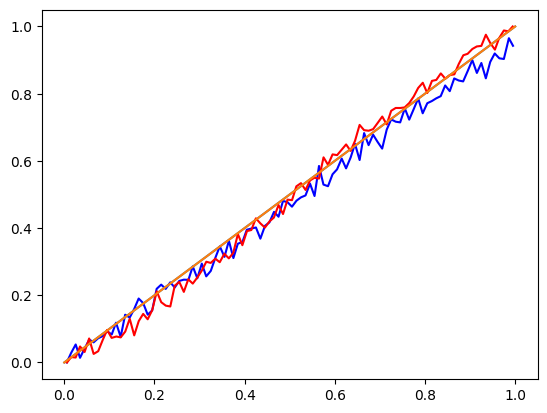

In [68]:
dataframe = pd.read_csv('../data/matches.csv')[7389:51327]
validation = pd.read_csv('../data/matches.csv')[51327:]
validation_2017 = pd.read_csv('../data/matches.csv')[51327:59482]
validation_2018 = pd.read_csv('../data/matches.csv')[59482:68158]
validation_2019 = pd.read_csv('../data/matches.csv')[68158:76425]


data_model, features_dict, labels = get_model(dataframe, hidden_layer, learning_rate, dropout)
_, val_features_dict, val_labels = get_model(validation, hidden_layer, learning_rate, dropout)
_, val_features_dict_2017, val_labels_2017 = get_model(validation_2017, hidden_layer, learning_rate, dropout)
_, val_features_dict_2018, val_labels_2018 = get_model(validation_2018, hidden_layer, learning_rate, dropout)
_, val_features_dict_2019, val_labels_2019 = get_model(validation_2019, hidden_layer, learning_rate, dropout)

reloaded = tf.keras.models.load_model('hidden1200lr0.0005dropout0.45trial1')
print('validation_overall')
results = reloaded.evaluate(val_features_dict, val_labels)
print('validation_2017')
results = reloaded.evaluate(val_features_dict_2017, val_labels_2017)
print('validation_2018')
results = reloaded.evaluate(val_features_dict_2018, val_labels_2018)
print('validation_2019')
results = reloaded.evaluate(val_features_dict_2019, val_labels_2019)
print('training')
results = reloaded.evaluate(features_dict, labels)

val_predictions = reloaded.predict(val_features_dict)
val_labels_list = val_labels.tolist()

predictions = reloaded.predict(features_dict)
labels_list = labels.tolist()

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

x, y = calibration_curve(val_labels_list, val_predictions, n_bins = 100)
plt.plot(y, x, 'b')
plt.plot([0, 1], [0, 1])

x, y = calibration_curve(labels_list, predictions, n_bins = 100)
plt.plot(y, x, 'r')
plt.plot([0, 1], [0, 1])

